# 사전 학습된 CNN(VGG-16)을 이용한 Fine Tunig
## VGG-16 Model
* University of Oxford - Visual Geometry Group
* 2014 ILSVRC 2nd Model
* ImageNet Large Scale Visual Recognition Challenge (ILSVRC)


In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Tensorflow

In [2]:
import tensorflow

tensorflow.__version__

'2.5.0'

# II. Image_File Directory Setting

* train_dir
* valid_dir
* test_dir

In [3]:
train_dir = './datasets/dogs_and_cats_small/train'
valid_dir = './datasets/dogs_and_cats_small/validation'
test_dir = './datasets/dogs_and_cats_small/test'

# III. Data Preprocessing

> ## 1) ImageDataGenerator( ) & flow_from_directory( )

* Normalization
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_directory( )

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# IV. Import VGG-16 Model & Some Layers Freezing

> ## 1) conv_base

In [5]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,  # DNN Network는 제외하고 가져오기
                  input_shape = (150, 150, 3))

58892288/58889256 [==============================] - 2s 0us/step


> ## 2) Model Information

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

> ## 3) 'block5_conv1' Freezing

* Before 'weight' Freezing

In [7]:
print('conv_base 동결 전 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 전 훈련 가능 가중치의 종류: 26


* 'weight' Freezing

In [8]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

* After 'weight' Freezing

In [9]:
print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 후 훈련 가능 가중치의 종류: 6


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# V. Keras CNN Modeling with VGG-16 Freezed Layers

> ## 1) Model Define

* 'conv_base' & 'Classification' Network
* Dropout Layer

In [11]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정
 * 이미 학습된 Weight 값을 Tuning
 * 매우 작은 Learnig Rate 지정
 * optimizers.Adam(lr = 0.000005)

In [13]:
from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 17분

In [14]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 21s 111ms/step - loss: 0.6595 - accuracy: 0.6240 - val_loss: 0.5095 - val_accuracy: 0.8050
Epoch 2/100
100/100 [==============================] - 11s 109ms/step - loss: 0.4377 - accuracy: 0.8035 - val_loss: 0.3427 - val_accuracy: 0.8700
Epoch 3/100
100/100 [==============================] - 11s 110ms/step - loss: 0.3056 - accuracy: 0.8800 - val_loss: 0.2657 - val_accuracy: 0.8880
Epoch 4/100
100/100 [==============================] - 11s 110ms/step - loss: 0.2364 - accuracy: 0.9065 - val_loss: 0.2279 - val_accuracy: 0.9050
Epoch 5/100
100/100 [==============================] - 11s 110ms/step - loss: 0.1846 - accuracy: 0.9230 - val_loss: 0.2049 - val_accuracy: 0.9120
Epoch 6/100
100/100 [==============================] - 11s 110ms/step - loss: 0.1551 - accuracy: 0.9420 - val_loss: 0.1949 - val_accuracy: 0.9160
Epoch 7/100
100/100 [==============================] - 11s 110ms/step - loss: 0.1255 - accuracy: 0.9540 - val_loss: 0.1886 -

100/100 [==============================] - 11s 111ms/step - loss: 2.7833e-04 - accuracy: 1.0000 - val_loss: 0.3225 - val_accuracy: 0.9280
Epoch 57/100
100/100 [==============================] - 11s 111ms/step - loss: 1.7931e-04 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9280
Epoch 58/100
100/100 [==============================] - 11s 111ms/step - loss: 1.8869e-04 - accuracy: 1.0000 - val_loss: 0.3363 - val_accuracy: 0.9290
Epoch 59/100
100/100 [==============================] - 11s 113ms/step - loss: 1.3601e-04 - accuracy: 1.0000 - val_loss: 0.3381 - val_accuracy: 0.9310
Epoch 60/100
100/100 [==============================] - 11s 113ms/step - loss: 1.2801e-04 - accuracy: 1.0000 - val_loss: 0.3368 - val_accuracy: 0.9280
Epoch 61/100
100/100 [==============================] - 11s 112ms/step - loss: 1.2117e-04 - accuracy: 1.0000 - val_loss: 0.3396 - val_accuracy: 0.9290
Epoch 62/100
100/100 [==============================] - 11s 112ms/step - loss: 1.1263e-04 - accuracy: 1.000

> ## 4) 학습 결과 시각화

* Loss Visualization

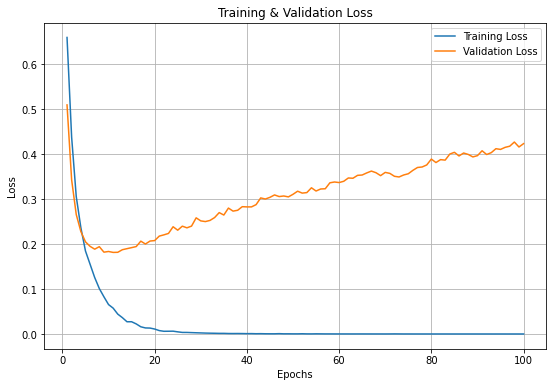

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

* Accuracy Visualization

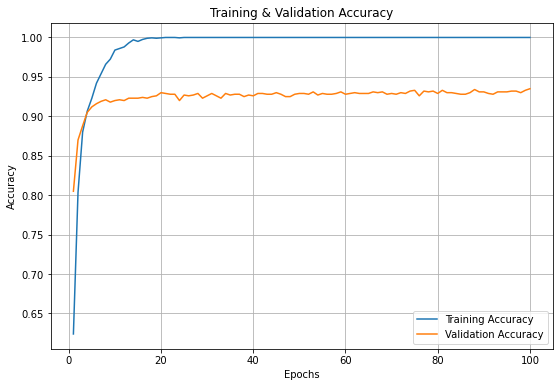

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate

* test_generator

In [17]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


* Loss & Accuracy

In [18]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 3s 64ms/step - loss: 0.4401 - accuracy: 0.9300 1s
Loss = 0.44011
Accuracy = 0.93000


# IV. Model Save

> ## Model Save

In [19]:
model.save('./models/005_dogs_and_cats_fine_tuning.h5')

> ## Model Load

In [20]:
from tensorflow.keras.models import load_model

model_google = load_model('./models/005_dogs_and_cats_fine_tuning.h5')

In [21]:
loss, accuracy = model_google.evaluate(test_generator,
                                       steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 3s 63ms/step - loss: 0.4401 - accuracy: 0.9300
Loss = 0.44011
Accuracy = 0.93000
